In [1]:
import pandas as pd

from IPython.display import display

import visuals as vs
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

# prediction_dt is 1 month ahead of active_as_of_dt and they should be month-ends
def get_customer_status(prediction_dt, active_as_of_dt):
    #df = spark.read.format("csv").option("header", "true").option("delimiter", "\t").load("customer_status_history_train.csv.gz")
    df = pd.read_csv("customer_status_history_train.csv",sep='\t')
    #status = df.filter(df.snapshot_day <= prediction_dt).toPandas()
    status = df[df['snapshot_day']<=prediction_dt]
    status.snapshot_day = pd.to_datetime(status.snapshot_day, format='%Y-%m-%d')
    prior_month = status[status.snapshot_day <= active_as_of_dt].groupby('customer_id')
    # pick the last status of the month
    x = prior_month.last()

    res = prior_month['snapshot_day'].agg({'enter': 'first', 'exit': 'last'})

    res['time_diff'] = res['exit'] - res['enter']
    
    active_customers = x[x.ku_status == 'PAID ACTIVE'].index
    
#     print res.columns.values
    prediction_month = status[status.snapshot_day <= prediction_dt].groupby('customer_id')
    # set the last status of the month (in case the status flipped within the month)
    x = prediction_month.last()
    
    completedf = pd.merge(x, res, left_index=True, right_index=True)

    completedf.time_diff = completedf.time_diff.dt.days
    
    completedf.drop(['enter','exit'], axis=1, inplace=True)
    
    prediction_month_status = completedf[completedf.index.isin(active_customers)]
    
    return prediction_month_status


In [2]:
status = get_customer_status('2017-08-31', '2017-07-31')
status.head(5)

C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


,snapshot_day,ku_status,time_diff
customer_id,,,
00012d5c5b3caba6486bf760f154a1a1310603a87a233982f19365ed4af4b60f,2017-08-10,PAID CANCELLED,20
000151374577dd6fe194237e23627f83541bcc39926089d7f63bc041c7fafe67,2017-08-24,PAID CANCELLED,0
00015215c16e4586578b42c2ee8535cbcec8e93bf2b62c78dfcbc059573d58b1,2017-02-01,PAID ACTIVE,33
000152eaa0928969c1da93e930e2944698e21594729f6ae7182e8cda46233c46,2017-08-20,PAID CANCELLED,47
0001d4efe1974e3d822ebed0ac4bc05cf85da8a8b61d839a504b9c3d92c4f53b,2017-05-12,PAID ACTIVE,0


In [3]:
import pandas as pd
def get_customer_activity_features(month_end_dt):
    # Read the purchase history file in
    # ph = spark.read.format("csv").option("header", "true").option("delimiter", "\t").load("customer_purchase_history.csv.gz")
    ph = pd.read_csv("customer_purchase_history.csv",sep='\t')
    data = ph[ph['snapshot_day']==month_end_dt]
    cust_features = data[['customer_id', 'paid_units_mtd', 'ku_loans_t7', 'ku_loans_mtd', 'free_units_mtd', 'pbook_units_mtd']]
    # Cheat by filtering on the month end summary record. Pick only paid units and ku loans month-to-date
    #cust_features = ph.filter(ph.snapshot_day == month_end_dt).select(['customer_id', 'paid_units_mtd', 'ku_loans_t7', 'ku_loans_mtd', 'free_units_mtd', 'pbook_units_mtd']).toPandas()
    # Convert to integer type
    cust_features.paid_units_mtd = cust_features.paid_units_mtd.astype(int)
    cust_features.ku_loans_mtd = cust_features.ku_loans_mtd.astype(int)
    cust_features.ku_loans_t7 = cust_features.ku_loans_t7.astype(int)
    cust_features.free_units_mtd = cust_features.free_units_mtd.astype(int)
    cust_features.pbook_units_mtd = cust_features.pbook_units_mtd.astype(int)
    return cust_features
    # cust_features[(cust_features.paid_units_mtd != 0) & (cust_features.ku_loans_mtd != 0)].count()


In [4]:
def get_customer_device_features(month_end_dt):
    # Read the device history file in
    # dh = spark.read.format("csv").option("header", "true").option("delimiter", "\t").load("customer_device_history.csv.gz")
    dh = pd.read_csv("customer_device_history.csv",sep='\t')
    data = dh[dh['snapshot_day']<= month_end_dt]
    cust_features = data[['snapshot_day', 'customer_id', 'active_android', 'active_kcp', 'active_ios', 'active_kcr', 'active_tablet', 'active_eink', 'active_phone', 'active_firetv']]
    # Convert to integer type
    #cust_features.active_android = cust_features.active_android.astype(float)
    
    #cust_features.active_android.fillna(0, inplace=True)
    #cust_features.active_android = cust_features.active_android.astype(int)
    #cust_features = cust_features.groupby('customer_id')['active_android'].last()
    
    #cust_features = pd.Series.to_frame(cust_features)
#     cust_features.head(10)
    cust_features['num_active'] = cust_features.sum(axis=1)
    
    cust_features.num_active = cust_features.num_active.astype(float)
    cust_features.num_active.fillna(0, inplace=True)
    cust_features.num_active = cust_features.num_active.astype(int)
    cust_features = cust_features.groupby('customer_id')['num_active'].last()
    return cust_features
    # cust_features[(cust_features.paid_units_mtd != 0) & (cust_features.ku_loans_mtd != 0)].count()

# device_counts = get_customer_device_features('2017-08-31')
# device_counts.head()

In [5]:
device_counts = get_customer_device_features('2017-07-31')
device_counts.head(3)

C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda2\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\Anaconda2\lib\site-packages\pandas\core\generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inp

customer_id
00006cbd025f7b0b3f894b319efccde84f1b059bf7b76f0a44de15e6fd19e82e    2
0000dfb1ac7e6ffb2e8f0f4e14271afa87cf0c5cddc030916709d13ef1763d76    2
0000e2aee8f9a5f294b1d8f765c8848e00eb051cc4faaa3ab4eb75c879dbcb7b    3
Name: num_active, dtype: int32

In [0]:
# Code to save intermediate data frames to CSV
# from io import BytesIO
# import boto3
# from boto3.session import Session

# # To be used in eider workspace only (references variables provided by eider)
# def write_to_s3(df, bucket, key):
#     session = Session(aws_access_key_id=awsAccessKeyId, aws_secret_access_key=awsSecretKey)
#     s3_resource = session.resource("s3")
#     csv_buffer = BytesIO()
#     df.to_csv(csv_buffer)
#     # s3_resource.Object('emr-eldorado', 'cust_features.csv').put(Body=csv_buffer.getvalue())
#     s3_resource.Object(bucket, username + "/" + key).put(Body=csv_buffer.getvalue())

In [6]:
x = get_customer_activity_features('2017-07-31')
x.index = x.customer_id
x = x.drop('customer_id', axis=1)

status = get_customer_status('2017-08-31', '2017-07-31')
status.head(5)
x =  x[x.index.isin(status.index)]
x['status'] = status[status.index.isin(x.index)]['ku_status']
print x.shape
# x['num_days'] = status[status.index.isin(x.index)]['time_diff']
df1 = status[['time_diff']]
x = pd.merge(x,df1 , left_index=True, right_index=True)
print x.shape
device_counts = get_customer_device_features('2017-07-31')
#x['active_android'] = device_counts[device_counts.index.isin(x.index)]
x['num_active'] = device_counts[device_counts.index.isin(x.index)]

x.head(5)
# write_to_s3(x, 'ml-hack-subs-data', 'prepared-dataset-2017-08-31.csv')

C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


(65456, 6)
(65456, 7)


C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,paid_units_mtd,ku_loans_t7,ku_loans_mtd,free_units_mtd,pbook_units_mtd,status,time_diff,num_active
customer_id,,,,,,,,
18272f7fb12370c0a3f3f7b199d5d691be231ac491257c4c342611fe5998643b,19,2,25,13,14,PAID ACTIVE,0,3
826a38e1a5bcf566411f775491ec3aa0ecd6d7d5f2e8c5cf781c0a1836da5320,0,0,2,2,2,PAID ACTIVE,175,6
0c0d145bbab185dc3b9940c54e9d26be7da9df116a6b0ff0f4df0a02eba3e20b,0,0,1,0,0,PAID ACTIVE,152,2
01278220976bcc9a1efb7bf086e40013b89101f37b1df7060c0867fc33adb4ce,2,0,0,0,1,PAID ACTIVE,248,9
4ed3507f64b47b9fe6bdc0681367c9085f8d3814dab726373a9542487edda598,0,0,0,0,0,PAID ACTIVE,0,3


(60000, 70000)

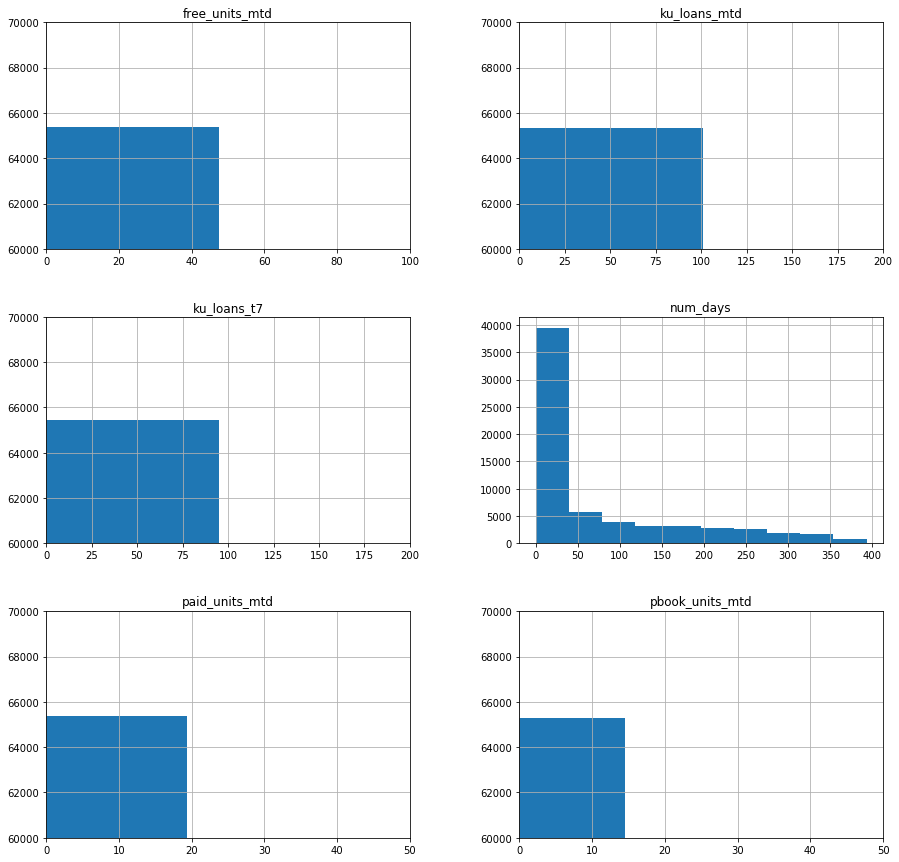

In [228]:
# ax_list=pd.DataFrame.hist(x,['paid_units_mtd','ku_loans_t7','ku_loans_mtd','free_units_mtd','pbook_units_mtd','num_days'],figsize =(15,15))
# ax_list[0][0].set_xlim((0,100))
# ax_list[0][0].set_ylim((60000,70000))
# ax_list[0][1].set_xlim((0,200))
# ax_list[0][1].set_ylim((60000,70000))
# ax_list[1][0].set_xlim((0,200))
# ax_list[1][0].set_ylim((60000,70000))
# # ax_list[1][1].set_xlim((0,20))
# ax_list[2][0].set_xlim((0,50))
# ax_list[2][0].set_ylim((60000,70000))
# ax_list[2][1].set_xlim((0,50))
# ax_list[2][1].set_ylim((60000,70000))

# # I don't see anything skewed

In [232]:
# Normalize

# # Import sklearn.preprocessing.StandardScaler
# from sklearn.preprocessing import MinMaxScaler

# # Initialize a scaler, then apply it to the features
# scaler = MinMaxScaler() # default=(0, 1)
# numerical = ['paid_units_mtd','ku_loans_t7','ku_loans_mtd','free_units_mtd','pbook_units_mtd','num_active','num_days']

# features_log_minmax_transform = pd.DataFrame(data = x)
# features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_minmax_transform[numerical])

# # Show an example of a record with scaling applied
# features_log_minmax_transform.head(n = 5)

,paid_units_mtd,ku_loans_t7,ku_loans_mtd,free_units_mtd,pbook_units_mtd,status,num_days,num_active
customer_id,,,,,,,,
18272f7fb12370c0a3f3f7b199d5d691be231ac491257c4c342611fe5998643b,0.097938,0.00211,0.024802,0.027426,0.095890,PAID ACTIVE,0.000000,0.049180
826a38e1a5bcf566411f775491ec3aa0ecd6d7d5f2e8c5cf781c0a1836da5320,0.000000,0.00000,0.001984,0.004219,0.013699,PAID ACTIVE,0.445293,0.098361
0c0d145bbab185dc3b9940c54e9d26be7da9df116a6b0ff0f4df0a02eba3e20b,0.000000,0.00000,0.000992,0.000000,0.000000,PAID ACTIVE,0.386768,0.032787
01278220976bcc9a1efb7bf086e40013b89101f37b1df7060c0867fc33adb4ce,0.010309,0.00000,0.000000,0.000000,0.006849,PAID ACTIVE,0.631043,0.147541
4ed3507f64b47b9fe6bdc0681367c9085f8d3814dab726373a9542487edda598,0.000000,0.00000,0.000000,0.000000,0.000000,PAID ACTIVE,0.000000,0.049180


In [233]:
# features_after_removing_outliers = features_log_minmax_transform.copy()
# for feature in features_log_minmax_transform.keys():
    
#     if feature == 'status':
#         continue
#     # TODO: Calculate Q1 (25th percentile of the data) for the given feature
#     Q1 = np.percentile(features_log_minmax_transform[feature],25)
    
#     # TODO: Calculate Q3 (75th percentile of the data) for the given feature
#     Q3 = np.percentile(features_log_minmax_transform[feature],75)
    
#     # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
#     step = (Q3-Q1)*2
    
#     # Display the outliers
#     #print "Data points considered outliers for the feature '{}':".format(feature)
#     features_after_removing_outliers.drop(features_log_minmax_transform[~((features_log_minmax_transform[feature] >= Q1 - step) & (features_log_minmax_transform[feature] <= Q3 + step))].index)
    
# # OPTIONAL: Select the indices for data points you wish to remove
# # outliers  = [75,154,66]

# # # Remove the outliers, if any were specified
# # good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

In [11]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

df = x[(x.status == 'PAID ACTIVE') | (x.status == 'PAID CANCELLED')]
df.head(5)
# target, features = dmatrices('status ~ paid_units_mtd + ku_loans_mtd + free_units_mtd + pbook_units_mtd + num_active',
#                   df, return_type="dataframe")
target, features = dmatrices('status ~ ku_loans_mtd + ku_loans_t7 + num_active',
                  df, return_type="dataframe")
print features.columns
features.head(5)
print target.head()

#Set 1 to indicte customer churn, 0 otherwise
target['status'] = target['status[PAID CANCELLED]']
target = target['status']
# make it a 1d array
target = np.ravel(target)
print target.size

#Split into training and test sets
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

# instantiate a logistic regression model, and fit with features and target
# model = LogisticRegression()

Index([u'Intercept', u'ku_loans_mtd', u'ku_loans_t7', u'num_active'], dtype='object')
                                                                  status[PAID ACTIVE]  \
customer_id                                                                             
18272f7fb12370c0a3f3f7b199d5d691be231ac491257c4c342611fe5998643b  1.0                   
826a38e1a5bcf566411f775491ec3aa0ecd6d7d5f2e8c5cf781c0a1836da5320  1.0                   
0c0d145bbab185dc3b9940c54e9d26be7da9df116a6b0ff0f4df0a02eba3e20b  1.0                   
01278220976bcc9a1efb7bf086e40013b89101f37b1df7060c0867fc33adb4ce  1.0                   
4ed3507f64b47b9fe6bdc0681367c9085f8d3814dab726373a9542487edda598  1.0                   

                                                                  status[PAID CANCELLED]  
customer_id                                                                               
18272f7fb12370c0a3f3f7b199d5d691be231ac491257c4c342611fe5998643b  0.0                     
826a38e1a5bcf5664

In [12]:
from sklearn.grid_search import GridSearchCV

from sklearn.metrics import fbeta_score, make_scorer

# from sklearn import svm

from sklearn.ensemble import RandomForestClassifier

# TODO: Make an fbeta_score scoring object using make_scorer()
# scorer = make_scorer(fbeta_score, beta=0.5)
def custom_auc(ground_truth, predictions):
     # I need only one column of predictions["0" and "1"]. You can get an error here
     # while trying to return both columns at once
     fpr, tpr, _ = metrics.roc_curve(ground_truth, predictions[:, 1], pos_label=1)    
     return metrics.auc(fpr, tpr)

# to be standart sklearn's scorer        
# scorer = make_scorer(custom_auc, greater_is_better=True, needs_proba=False)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()

#Random Forest
max_depth = [i for i in range(5,15)]
min_samples_split = [i for i in range(5,15)]
n_estimators = [20]
parameters = {'max_depth':max_depth,'min_samples_split':min_samples_split,'n_estimators':n_estimators}
RFC=RandomForestClassifier()
grid_obj = GridSearchCV(RFC, parameters,cv=5)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(features_train,target_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

print grid_fit.best_params_ 

# Make predictions using the unoptimized and model
predicted = (best_clf.fit(features_train, target_train)).predict(features_test)

print predicted

# Check to see if it identifies anyone as churning
predicted.size
np.sum(predicted)

probs = model.predict_proba(features_test)
print probs

print metrics.accuracy_score(target_test, predicted)
# The metric we use in leaderboard
print metrics.roc_auc_score(target_test, probs[:, 1])

print metrics.confusion_matrix(target_test, predicted)
print metrics.classification_report(target_test, predicted)

C:\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


{'min_samples_split': 12, 'n_estimators': 20, 'max_depth': 8}
[ 0.  0.  0. ...,  0.  0.  0.]
[[ 0.80608908  0.19391092]
 [ 0.82381341  0.17618659]
 [ 0.8880368   0.1119632 ]
 ..., 
 [ 0.81561292  0.18438708]
 [ 0.79533654  0.20466346]
 [ 0.83737142  0.16262858]]
0.809543209248
0.615429008127
[[15886    20]
 [ 3720    11]]
             precision    recall  f1-score   support

        0.0       0.81      1.00      0.89     15906
        1.0       0.35      0.00      0.01      3731

avg / total       0.72      0.81      0.73     19637



In [10]:
testdf = pd.read_csv('public_test_set.csv')
print testdf.shape
testdf.rename(columns={'Id': 'customer_id'}, inplace=True)
testdf.index = testdf.customer_id
testdf = testdf.drop('customer_id', axis=1)

testfeatures = get_customer_activity_features('2017-08-31')
testfeatures.index = testfeatures.customer_id
testfeatures = testfeatures.drop('customer_id', axis=1)
print "activity features"
print testfeatures.shape

device_counts = get_customer_device_features('2017-08-31')
#x['active_android'] = device_counts[device_counts.index.isin(x.index)]
testfeatures['num_active'] = device_counts[device_counts.index.isin(testfeatures.index)]
print testfeatures.shape
testfeatures.head(5)
# write_to_s3(x, 'ml-hack-subs-data', 'prepared-dataset-2017-08-31.csv')

testfeaturesfinal = pd.merge(testfeatures, testdf, left_index=True, right_index=True, how="right")
testfeaturesfinal.fillna(0, inplace=True)
testfeaturesfinal.head(5)
print testfeaturesfinal.shape
# target, features = dmatrices('status ~ paid_units_mtd + ku_loans_mtd + free_units_mtd + pbook_units_mtd + num_active',
#                   df, return_type="dataframe")
testfinalfeatures = testfeaturesfinal[['ku_loans_mtd', 'ku_loans_t7', 'num_active']]
# target, testfinalfeatures = dmatrices('status ~ ku_loans_mtd + ku_loans_t7 + time_diff + num_active + paid_units_mtd + free_units_mtd + ku_loans_mtd_june + ku_loans_t7_june + free_units_mtd_june + ku_loans_mtd_may + ku_loans_t7_may + free_units_mtd_may',
#                   df, return_type="dataframe")
testfinalfeatures.fillna(0, inplace=True)

Intercept = [1.0]*67588
se = pd.Series(Intercept)
testfinalfeatures['Intercept'] = se.values

print testfinalfeatures.shape
predicted = model.predict(testfinalfeatures)
print predicted.shape

se = pd.Series(predicted)
print testfinalfeatures.shape
testfinalfeatures['ku_status'] = se.values
print testfinalfeatures.shape
outputpd = testfinalfeatures[['ku_status']]
outputpd.ku_status = outputpd.ku_status.astype(int)
outputpd.head(10)
outputpd.index.names = ['ID']
outputpd.to_csv(r'C:\Users\choppak\Desktop\Lstudy\MLND\KU prediction\output_3.csv', sep=',', mode='a')
outputpd.shape


(67588, 1)
activity features
(141911, 5)


C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


(141911, 6)
(67588, 6)


C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(67588, 4)
(67588L,)
(67588, 4)
(67588, 5)


(67588, 1)

In [21]:
corr = pd.DataFrame()
corr['prob'] = probs[:,1]
corr['status'] = target_test
corr.sort_values(by='status').tail()
plt.scatter(corr['prob'], corr['status'])

In [0]:
device_counts['18272f7fb12370c0a3f3f7b199d5d691be231ac491257c4c342611fe5998643b']